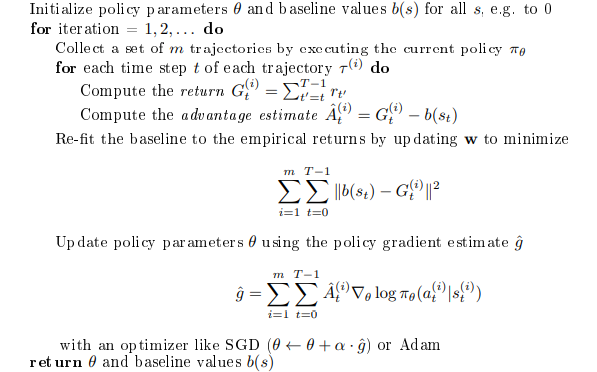

In this algorithm, instead of using actual returns(Gt) from the environment to estimate Qπθ (s, a), we can get the estimate of state-action values from the following equation:

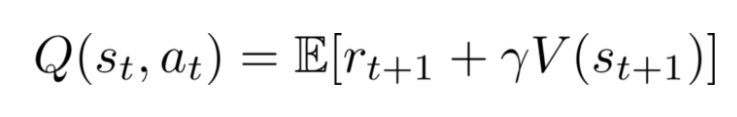

By doing so, we would get advantage actor-critic algorithm.

In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distributions

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
train_env = gym.make("CartPole-v1")
test_env = gym.make("CartPole-v1")

In [5]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.dropout(self.fc1(x))
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [6]:
class PolicyValueNet(nn.Module):
    def __init__(self, policy_net, value_net):
        super().__init__()
        self.policy_net = policy_net
        self.value_net = value_net

    def forward(self, x):
        actions = self.policy_net(x)
        values = self.value_net(x)
        return actions, values

In [7]:
def init_parameters(p):
    if type(p) == nn.Linear:
        nn.init.xavier_normal_(p.weight)
        p.bias.data.fill_(0)

In [8]:
def train(env, pvnet, gamma, opt):
    pvnet.train()
    ep_reward = 0
    values = []
    rewards = []
    log_prob_actions = []
    state = env.reset()
    done = False

    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        actions, value_pred = pvnet(state)
        actions_softmax = F.softmax(actions, dim=-1)

        dist = distributions.Categorical(actions_softmax)
        action = dist.sample()
        log_prob_a = dist.log_prob(action)
        
        state, reward, done, _ = env.step(action.item())
        rewards.append(reward)
        log_prob_actions.append(log_prob_a)
        values.append(value_pred)
        ep_reward += reward

    log_prob_actions = torch.cat(log_prob_actions).to(device)
    values = torch.cat(values).squeeze(-1).to(device)
    returns = get_returns(rewards, gamma)
    advantages = get_advantages(returns, values)

    policy_loss, value_loss = update_pvnet_params(returns, log_prob_actions, values, advantages, opt)
    return policy_loss, value_loss, ep_reward

In [9]:
def get_returns(rewards, gamma):
    returns = []
    R = 0
    for r in reversed(rewards):
        R = r + gamma * R
        returns.insert(0, R)
    
    returns = torch.tensor(returns).to(device)
    returns = (returns - returns.mean()) / returns.std()
    return returns

In [10]:
def get_advantages(returns, values):
    advantages = returns - values
    advantages = (advantages - advantages.mean()) / advantages.std()
    return advantages.to(device)

In [11]:
def update_pvnet_params(returns, log_prob_actions, values, advantages, opt):
    advantages.detach_()
    returns.detach_()
    policy_loss = - (advantages * log_prob_actions).sum()
    value_loss = F.smooth_l1_loss(returns, values).sum()

    opt.zero_grad()
    policy_loss.backward()
    value_loss.backward()
    opt.step() 
    return policy_loss.item(), value_loss.item()

In [12]:
def evaluate(env, pvnet):
    pvnet.eval()
    ep_reward = 0
    state = env.reset()
    done = False

    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            actions, _ = pvnet(state)
            action = torch.argmax(actions).item()

        state, reward, done, _ = env.step(action)
        ep_reward += reward
    return ep_reward

In [13]:
episodes = 501
gamma = 0.99
input_size = train_env.observation_space.shape[0]
hidden_size = 128
output_size = train_env.action_space.n
lr = 1e-3

In [14]:
policy_net = Net(input_size, hidden_size, output_size)
value_net = Net(input_size, hidden_size, 1)
pvnet = PolicyValueNet(policy_net, value_net)
pvnet.apply(init_parameters)
pvnet.to(device)

PolicyValueNet(
  (policy_net): Net(
    (fc1): Linear(in_features=4, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=2, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (value_net): Net(
    (fc1): Linear(in_features=4, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=1, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [15]:
opt = torch.optim.Adam(pvnet.parameters(), lr)
policy_losses = []
value_losses = []
train_rewards = []
test_rewards = []

In [18]:
for ep in range(episodes):
    policy_loss, value_loss, train_reward = train(train_env, pvnet, gamma, opt)
    test_reward = evaluate(test_env, pvnet)

    policy_losses.append(policy_loss)
    value_losses.append(value_loss)
    train_rewards.append(train_reward)
    test_rewards.append(test_reward)
    
    if ep % 50 == 0:
        pl = sum(policy_losses) / len(policy_losses)
        vl = sum(value_losses) / len(value_losses)
        trr = sum(train_rewards) / len(train_rewards)
        ter = sum(test_rewards) / len(test_rewards)
        print(f"episode: {ep} | policy_loss: {pl:.4f} | value_loss: {vl:.4f} | train_reward: {trr} | test_reward: {ter}")

        policy_losses = []
        value_losses = []
        train_rewards = []
        test_rewards = []

episode: 0 | policy_loss: 0.6781 | value_loss: 0.2979 | train_reward: 9.0 | test_reward: 10.0
episode: 50 | policy_loss: -0.0114 | value_loss: 0.4019 | train_reward: 24.9 | test_reward: 54.28
episode: 100 | policy_loss: -0.4462 | value_loss: 0.4052 | train_reward: 38.18 | test_reward: 192.68
episode: 150 | policy_loss: -1.0414 | value_loss: 0.3987 | train_reward: 43.3 | test_reward: 73.66
episode: 200 | policy_loss: -0.9836 | value_loss: 0.3992 | train_reward: 50.28 | test_reward: 102.68
episode: 250 | policy_loss: -1.1286 | value_loss: 0.3697 | train_reward: 56.1 | test_reward: 187.44
episode: 300 | policy_loss: -1.0759 | value_loss: 0.3214 | train_reward: 62.74 | test_reward: 165.4
episode: 350 | policy_loss: -1.7167 | value_loss: 0.2515 | train_reward: 70.62 | test_reward: 283.64
episode: 400 | policy_loss: -1.8916 | value_loss: 0.2027 | train_reward: 95.12 | test_reward: 419.72
episode: 450 | policy_loss: -4.0119 | value_loss: 0.2609 | train_reward: 184.06 | test_reward: 434.82
epi